In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from tqdm import trange


%matplotlib inline

# Observaciones de Steinhardt

En esta primera parte intentaré reajustar las predicciones teóricas que aparecen [*Steinhardt et al., 2016*](#Referencias) con los nuevos datos ajustados de [*Behroozi et al., 2019*](#Referencias). Para ello vamos a recopilar todos los datos usados por [*Steinhardt et al., 2016*](#Referencias) tanto para el ajuse teórico de la función de masa de halo ([Sheth et al. (2001)](#Referencias), [Murray et al. (2013)](#Referencias)) como para el tratamiento de los datos observacionales que se muestran en la imagen. <a href="images/stein_2.jpeg" target="_blank"><img src="images/stein_2.jpeg" style="width:30%"></a>
>*Theoretical halo number density as a function of halo
mass and redshift ([Sheth et al. (2001)](#Referencias), [Murray et al. (2013)](#Referencias)) for the
most massive halos at $4 < z < 10$ (shown as solid lines, with red-
der colors at higher redshift) compared with observational number
densities of estimated halo masses corresponding to observed star-
forming galaxies at similar redshifts. Halo masses are estimated
using clustering (triangle), stellar masses converted to halo masses
using thelow-redshift scaling ratio $M_H/M_\star \sim 70$ (square), and UV
luminosities converted to halo masses using ratios determined by
lower-redshift abundance matching (circle), as described in § 2,
for an overall $M_H/M\odot \sim 120 L_{UV}/L_\odot$. These methods all give
self-consistent number densities that disagree with theoretical ex-
pectations.*

Para ello recopilaremos los datos de los artículos citados [Hildebrandt et al. (2009)](#Referencias), [Bouwens et al. (2015a)](#Referencias), [Bouwens et al. (2015b)](#Referencias) y [Steinhardt et al. (2014)](#Referencias), donde aplicaremos la distribución de los datos encontrados en [Behroozi et al. (2019)](#Referencias) para recalcular los datos obtenidos de dichas observaciones. El esquema de este Notebook será el siguiente:

>1. Construiremos las distribuciones de los datos estudiados en [Behroozi et al. (2019)](#Referencias).
2. Estudiaremos las predicciones Teóricas sacadas de [Sheth et al. (2001)](#Referencias) y [Murray et al. (2013)](#Referencias).
3. Recopilaremos las observaciones de [Hildebrandt et al. (2009)](#Referencias), [Bouwens et al. (2015a)](#Referencias), [Bouwens et al. (2015b)](#Referencias) y [Steinhardt et al. (2014)](#Referencias).
4. Aplicaremos las distribuciones de los datos de [Behroozi et al. (2019)](#Referencias) a las funciones de masa de halo teóricas y a las derivadas por las observaciones.

## Observaciones

### [Hildebrandt et al. (2009)](#Referencias)

Los datos de [Hildebrandt et al. (2009)](#Referencias) fueron tomados del estudio CFHTLS - *Deep Survey* analizando los saltos en las magnitudes del filtro *u,g* y *r* para calcular su redshift fotométrico. Dichos datos los podemos encontrar en el archivo 'data_cfhtls.csv'.

In [158]:
cfhtl_data = pd.read_csv("CFHTLS_DeepSurvey/data_cfhtls.csv")

Como encontramos objetos donde no tenemos muestra en las magnitudes que desemos dichas observaciones las descartamos, reemplazando el hueco en blanco observado por un 'NaN'

In [4]:
valor_a_descartar = np.sort(cfhtl_data.gmag.unique())[0]

In [5]:
cfhtls_u = np.zeros(cfhtl_data.shape[0])
cfhtls_g = np.zeros(cfhtl_data.shape[0])
cfhtls_r = np.zeros(cfhtl_data.shape[0])
cfhtls_i = np.zeros(cfhtl_data.shape[0])
cfhtls_z = np.zeros(cfhtl_data.shape[0])

for k in range(cfhtl_data.shape[0]):
    u = cfhtl_data.umag.values[k]
    g = cfhtl_data.gmag.values[k]
    r = cfhtl_data.rmag.values[k]
    i = cfhtl_data.imag.values[k]
    z = cfhtl_data.zmag.values[k]
    cfhtls_u[k] = np.float(u.replace(valor_a_descartar,"NaN"))
    cfhtls_g[k] = np.float(g.replace(valor_a_descartar,"NaN"))
    cfhtls_r[k] = np.float(r.replace(valor_a_descartar,"NaN"))
    cfhtls_i[k] = np.float(i.replace(valor_a_descartar,"NaN"))
    cfhtls_z[k] = np.float(z.replace(valor_a_descartar,"NaN"))

In [6]:
mask = np.isnan(cfhtls_u) * np.isnan(cfhtls_g) * np.isnan(cfhtls_r) * np.isnan(cfhtls_i) * np.isnan(cfhtls_z)
cfhtls_u = cfhtls_u[~mask]
cfhtls_g = cfhtls_g[~mask]
cfhtls_r = cfhtls_r[~mask]
cfhtls_i = cfhtls_i[~mask]
cfhtls_z = cfhtls_z[~mask]

Una vez limpiado la muestra vacía gráficamos los resultados para detectar los saltos en las distintas magnitudes
> Saltos en u:
$$
1.5 < (u − g) ∧  −1.0 < (g − r) < 1.2 ∧
1.5 · (g − r) < (u − g) − 0.7
$$
Saltos en g:
$$
1.0 < (g − r) ∧ −1.0 < (r − i) < 1.0 ∧
1.5 · (r − i) < (g − r) − 0.8
$$
Saltos en z:
$$
1.2 < (r − i) ∧ −1.0 < (i − z) < 0.7 ∧
1.5 · (i − z) < (r − i) − 1.0
$$

In [7]:
u_g = cfhtls_u - cfhtls_g
g_r = cfhtls_g - cfhtls_r
r_i = cfhtls_r - cfhtls_i
i_z = cfhtls_i - cfhtls_z

u_drop= (u_g > 1.5) & (g_r > -1) & (g_r < 1.2) & ((u_g - 0.7)>1.5*g_r)
g_drop= (g_r > 1.0) & (r_i > -1) & (r_i < 1.0) & ((g_r - 0.8)>1.5*r_i)
z_drop= (r_i > 1.2) & (i_z > -1) & (i_z < 0.7) & ((r_i - 1.0)>1.5*i_z)                                      

/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Y realizamos las gráficas de los CFHTLS - Deep Survey

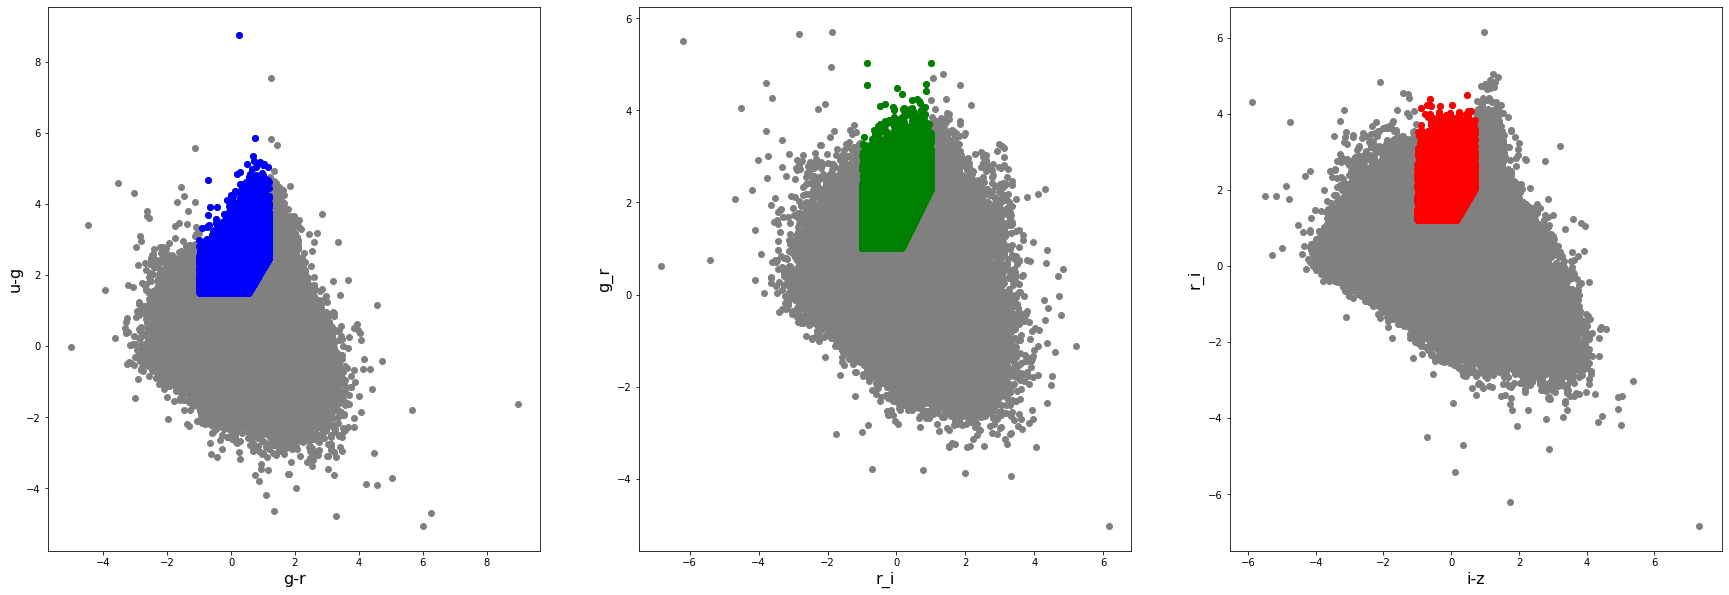

In [86]:
plt.figure(figsize=(30,10))
plt.title("Hildergberg CFHTLS Deep Survey", fontsize=20)

ax1=plt.subplot(1,3,1)
ax1.scatter(g_r,u_g, color="grey")
ax1.scatter(g_r[u_drop],u_g[u_drop], color="blue")
ax1.set_xlabel("g-r", fontsize=16)
ax1.set_ylabel("u-g", fontsize=16)

ax2=plt.subplot(1,3,2)
ax2.scatter(r_i,g_r, color="grey")
ax2.scatter(r_i[g_drop],g_r[g_drop], color="green")
ax2.set_xlabel("r-i", fontsize=16)
ax2.set_ylabel("g-r", fontsize=16)

ax3=plt.subplot(1,3,3)
ax3.scatter(i_z,r_i, color="grey")
ax3.scatter(i_z[z_drop],r_i[z_drop], color="red")
ax3.set_xlabel("i-z", fontsize=16)
ax3.set_ylabel("r-i", fontsize=16)

plt.savefig("Test.png")

### Sec 3 -- The LBG samples

Las simulaciones toman como referencia para la creación del catálog el número de muestras registradas en la banda *i* de las observaciones

In [8]:
i_counts = np.count_nonzero(cfhtls_i)
print("El número de cuentas registradas en la banda i es de %.i" % (i_counts))

El número de cuentas registradas en la banda i es de 2254580


Sigamos todos los pasos que sigue HILDEBRANDT

In [34]:
i_udrops=cfhtls_i[g_drop]
i_bins = np.arange(23,28,0.5)

i_counts = np.array([np.count_nonzero(i_udrops==i) for i in i_bins])

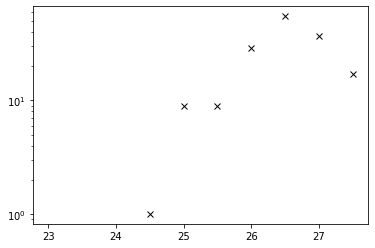

In [37]:
plt.plot(i_bins,i_counts,"kx")
plt.yscale("log")

## Método de enlace de abundancias

El método de enlace de abundancias que se muestra en [Finkelstein et al. (2015b)](#Referencias) se base en enlazar la función de luminosidad con la función de masa de halo para así obtener la masa del halo en función de la luminosidad de la galaxia. La hipótesis aceptada para usar este método es la suposición de que las galaxias más masivas se encuentran alojadas en los halos más masivos, de esta manera enlazan la función de luminosidad de Shecter cuyo ajuste es estudiado en [Finkestein et al. (2015a)](#Referencias) con la función de masa de halo obtenida de las simulaciones de Bolshoi por medio del número de densidad obtenido por ambas funciones, como se puede observar en la figura de más abajo
<a href="images/fink_2015b_1.jpg" target="_blank"><img src="images/fink_2015b_1.jpg"></a>

### Datos de [Finkelstein et al. (2015a), (2015b) ](#Referencias)

Los datos de [Finkelstein et al. (2015b)](#Referencias) es una submuestra de las casi 7500 galaxias estudiadas en [Finkelstein et al. (2015a)](#Referencias) en donde da una aproximación de la función de luminosidad de Shecter para diferentes rangos de redshift de la muestra estudiada:

$$
\varphi(M)=0.4 \ln (10) \varphi^{*} 10^{-0.4\left(M-M^{*}\right)(\alpha+1)} e^{-10^{-0.4\left(M-M^{*}\right)}}
$$

En donde los ajustes obtenidos para los valores de $\alpha, M^*, \varphi^*$ son:
$$
\begin{array}{cccc}
    \hline 
    \text { Redshift } & {M^{*}} & {\alpha} & {\varphi^{*}} \\ 
    &  & & {\left(\text{Mpc}^{*}-3\right)} \\ 
    \hline \\
    4 & {-20.73_{-0.09}^{+0.09}} & {-1.56_{-0.05}^{+0.06}} & {\left(14.1_{-1.85}^{+2.05}\right) \times 10^{-4}} \\ 
    {5} & {-20.81_{-0.12}^{+0.13}} & {-1.67_{-0.06}^{+0.05}} & {\left(8.95_{-1.31}^{+1.92}\right) \times 10^{-4}} \\ 
    {6} & {-21.13_{-0.31}^{+0.25}} & {-2.02_{-0.10}^{+0.10}} & {\left(1.86_{-0.8}^{+0.94}\right) \times 10^{-4}} \\ 
    {7} & {-21.03_{-0.50}^{+0.37}} & {-2.03_{-0.20}^{+0.21}} & {\left(1.57_{-0.95}^{+1.49}\right) \times 10^{-4}} \\ 
    {8} & {-20.89_{-1.08}^{+0.74}} & {-2.36_{-0.40}^{+0.54}} & {\left(0.72_{-0.65}^{+2.52}\right) \times 10^{-4}} \\ 
    \hline
\end{array}
$$

In [19]:
def phi(M,z):
    
    m,a,p = [0,0,0]
    if z>3.5 and z<= 4.5:
        m,a,p = [-20.73,-1.56,14.1*10**(-4)]
    elif z>4.5 and z<=5.5:
        m,a,p = [-20.81,-1.67,8.95*10**(-4)]
    elif z>5.5 and z<=6.5:
        m,a,p = [-21.13,-2.02,1.86*10**(-4)]
    elif z>6.5 and z<=7.5:
        m,a,p = [-21.03,-2.03,1.57*10**(-4)]
    elif z>7.5 and z<=8.5:
        m,a,p = [-20.89,-2.36,0.72*10**(-4)]
    
    
    part1=0.4*np.log(10)
    paw1= -0.4*(M-m)*(a+1)
    paw2= -np.power(10,-0.4*(M-m))
    part2=np.power(10,paw1)
    part3=np.exp(paw2)
    
    phi_value = part1*part2*part3*p
    
    return phi_value

Intentemos replicar los datos obtenidos en los estudios de Finkelstein y veamos como puede encajar las nuevas métricas obtenidos por [Behroozi et al. (2019)](#Referencias) y las nuevas observaciones de [Wang et al. (2019)](#Referencias)

In [20]:
fink_a = pd.read_csv("Finkelstein/ApJ810_2015/apj810.tsv", sep=";", skiprows=53, index_col=None)
fink_b = pd.read_csv("Finkelstein/ApJ814_2015/apj814.tsv", sep=";", skiprows=72, index_col=None)

fink_a = fink_a.iloc[2:,:]
fink_b = fink_b.iloc[2:,:]

In [21]:
fink_b.columns

col_fb= ['_RAJ2000', '_DEJ2000', 'ID', 'RAJ2000', 'DEJ2000', 'z', 'b_z', 'B_z',
       'logM*', 'b_logM*', 'B_logM*', 'Age', 'b_Age', 'B_Age', 'E(B-V)',
       'b_E(B-V)', 'B_E(B-V)', 'SFR', 'b_SFR', 'B_SFR', 'Simbad']

ids_fb= fink_b.ID.values
fink_a.ID = np.array([i.replace(" ","") for i in fink_a.ID.values])
test=fink_a.ID.isin(ids_fb)
sample = fink_a[test]
not_sample = fink_b[~(fink_b.ID.isin(fink_a.ID.values))]
sample


,_RAJ2000,_DEJ2000,ID,HRG14,RAJ2000,DEJ2000,zphot,b_zphot,B_zphot,1500Mag,b_1500Mag,B_1500Mag
30,053.09684000,-27.86607389,z4_GSD_34736,HRG14 J033223.24-275157.9,053.096840,-27.866074,3.51,0.38,3.64,-21.36,-21.50,-21.32
47,053.08689111,-27.84413889,z4_GSD_30292,HRG14 J033220.85-275038.9,053.086891,-27.844139,3.54,0.40,3.70,-21.03,-21.23,-20.98
177,053.08736806,-27.83953500,z4_GSD_29028,HRG14 J033220.97-275022.3,053.087368,-27.839535,3.60,3.48,3.73,-21.03,-21.14,-20.96
211,053.12141389,-27.81462111,z4_GSD_21002,HRG14 J033229.14-274852.6,053.121414,-27.814621,3.63,3.57,3.73,-21.18,-21.27,-21.13
215,053.03123889,-27.78521500,z4_GSD_11269,HRG14 J033207.50-274706.8,053.031239,-27.785215,3.63,3.53,3.77,-21.30,-21.41,-21.20
239,053.10742194,-27.86929889,z4_GSD_35257,HRG14 J033225.78-275209.5,053.107422,-27.869299,3.65,3.53,3.82,-21.09,-21.28,-21.04
261,053.07173500,-27.79843694,z4_GSD_15786,HRG14 J033217.22-274754.4,053.071735,-27.798437,3.67,3.59,3.74,-21.05,-21.13,-21.00
341,053.13885889,-27.83537111,z4_GSD_27735,HRG14 J033233.33-275007.3,053.138859,-27.835371,3.74,3.67,3.82,-21.20,-21.21,-21.10
407,053.06626111,-27.84905611,z4_GSD_31543,HRG14 J033215.90-275056.6,053.066261,-27.849056,3.81,3.68,3.94,-21.37,-21.42,-21.26
541,053.07618306,-27.86636000,z4_GSD_34857,HRG14 J033218.28-275158.9,053.076183,-27.866360,3.97,3.87,4.11,-21.80,-21.96,-21.76


In [22]:
m_fa = fink_a.loc[:,["zphot","1500Mag"]].astype(float)
z_fa = fink_a.zphot.astype(float)

mask_z4 = (z_fa >3.5) & (z_fa <= 4.5)
mask_z5 = (z_fa >4.5) & (z_fa <= 5.5)
mask_z6 = (z_fa >5.5) & (z_fa <= 6.5)
mask_z7 = (z_fa >6.5) & (z_fa <= 7.5)
mask_z8 = (z_fa >7.5) & (z_fa <= 8.5)

m_z4=m_fa[mask_z4]
m_z5=m_fa[mask_z5]
m_z6=m_fa[mask_z6]
m_z7=m_fa[mask_z7]
m_z8=m_fa[mask_z8]

In [23]:
def phi_obs(M,m_z, delta_M):
    n= M.shape[0]
    p_values=np.zeros(n)
    j=0
    for i in M:
        mask = (m_z["1500Mag"].values >i-delta_M) & (m_z["1500Mag"].values < i+delta_M)
        p_values[j] = np.sum(mask)
        j+=1
    
    return p_values/np.count_nonzero(m_z["1500Mag"].values)

In [24]:
phi_fink_z4=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z3.5_z4.5.uvlf",
                       skiprows=4, sep="\s", names=["bMag","BMag","phi","bphi","Bphi"])

phi_fink_z5=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z4.5_z5.5.uvlf",
                       skiprows=4, sep="\s", names=["bMag","BMag","phi","bphi","Bphi"])

phi_fink_z6=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z5.5_z6.5.uvlf",
                       skiprows=4, sep="\s", names=["bMag","BMag","phi","bphi","Bphi"])

phi_fink_z7=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z6.5_z7.5.uvlf",
                       skiprows=4, sep="\s", names=["bMag","BMag","phi","bphi","Bphi"])

phi_fink_z8=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z7.5_z8.5.uvlf",
                       skiprows=4, sep="\s", names=["bMag","BMag","phi","bphi","Bphi"])


/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/santi/anaconda3/lib/python3.7/site-p

In [25]:
M=np.arange(-23,-16.9,0.1)

In [26]:
hmf_z4=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.202435.dat", skiprows=2,sep="\s")
uvlf_z4=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.202435.dat", skiprows=3,sep="\s")

hmf_z5=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.166998.dat", skiprows=2,sep="\s")
uvlf_z5=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.166998.dat", skiprows=3,sep="\s")

hmf_z6=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.141685.dat", skiprows=2,sep="\s")
uvlf_z6=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.141685.dat", skiprows=3,sep="\s")

hmf_z7=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.126498.dat", skiprows=2,sep="\s")
uvlf_z7=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.126498.dat", skiprows=3,sep="\s")

hmf_z8=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.112998.dat", skiprows=2,sep="\s")
uvlf_z8=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.112998.dat", skiprows=3,sep="\s")


hmfs_list=[hmf_z4,hmf_z5,hmf_z6,hmf_z7,hmf_z8]
uvlfs_list=[uvlf_z4,uvlf_z5,uvlf_z6,uvlf_z7,uvlf_z8]

/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  

In [27]:
yerror_low=np.power(10,phi_fink_z4.phi.values)- np.power(10,phi_fink_z4.phi.values-phi_fink_z4.bphi.values)
yerror_up=(np.power(10,phi_fink_z4.phi.values + phi_fink_z4.Bphi.values)- np.power(10,phi_fink_z4.phi.values))
yerror_z4=np.array((yerror_low,yerror_up))
xerror_z4=(phi_fink_z4.BMag.values - phi_fink_z4.bMag.values)/2

yerror_low=np.power(10,phi_fink_z5.phi.values)- np.power(10,phi_fink_z5.phi.values-phi_fink_z5.bphi.values)
yerror_up=(np.power(10,phi_fink_z5.phi.values + phi_fink_z5.Bphi.values)- np.power(10,phi_fink_z5.phi.values))
yerror_z5=np.array((yerror_low,yerror_up))
xerror_z5=(phi_fink_z5.BMag.values - phi_fink_z5.bMag.values)/2

yerror_low=np.power(10,phi_fink_z6.phi.values)- np.power(10,phi_fink_z6.phi.values-phi_fink_z6.bphi.values)
yerror_up=(np.power(10,phi_fink_z6.phi.values + phi_fink_z6.Bphi.values)- np.power(10,phi_fink_z6.phi.values))
yerror_z6=np.array((yerror_low,yerror_up))
xerror_z6=(phi_fink_z6.BMag.values - phi_fink_z6.bMag.values)/2

yerror_low=np.power(10,phi_fink_z7.phi.values)- np.power(10,phi_fink_z7.phi.values-phi_fink_z7.bphi.values)
yerror_up=(np.power(10,phi_fink_z7.phi.values + phi_fink_z7.Bphi.values)- np.power(10,phi_fink_z7.phi.values))
yerror_z7=np.array((yerror_low,yerror_up))
xerror_z7=(phi_fink_z7.BMag.values - phi_fink_z7.bMag.values)/2

yerror_low=np.power(10,phi_fink_z8.phi.values)- np.power(10,phi_fink_z8.phi.values-phi_fink_z8.bphi.values)
yerror_up=(np.power(10,phi_fink_z8.phi.values + phi_fink_z8.Bphi.values)- np.power(10,phi_fink_z8.phi.values))
yerror_z8=np.array((yerror_low,yerror_up))
xerror_z8=(phi_fink_z8.BMag.values - phi_fink_z8.bMag.values)/2

/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


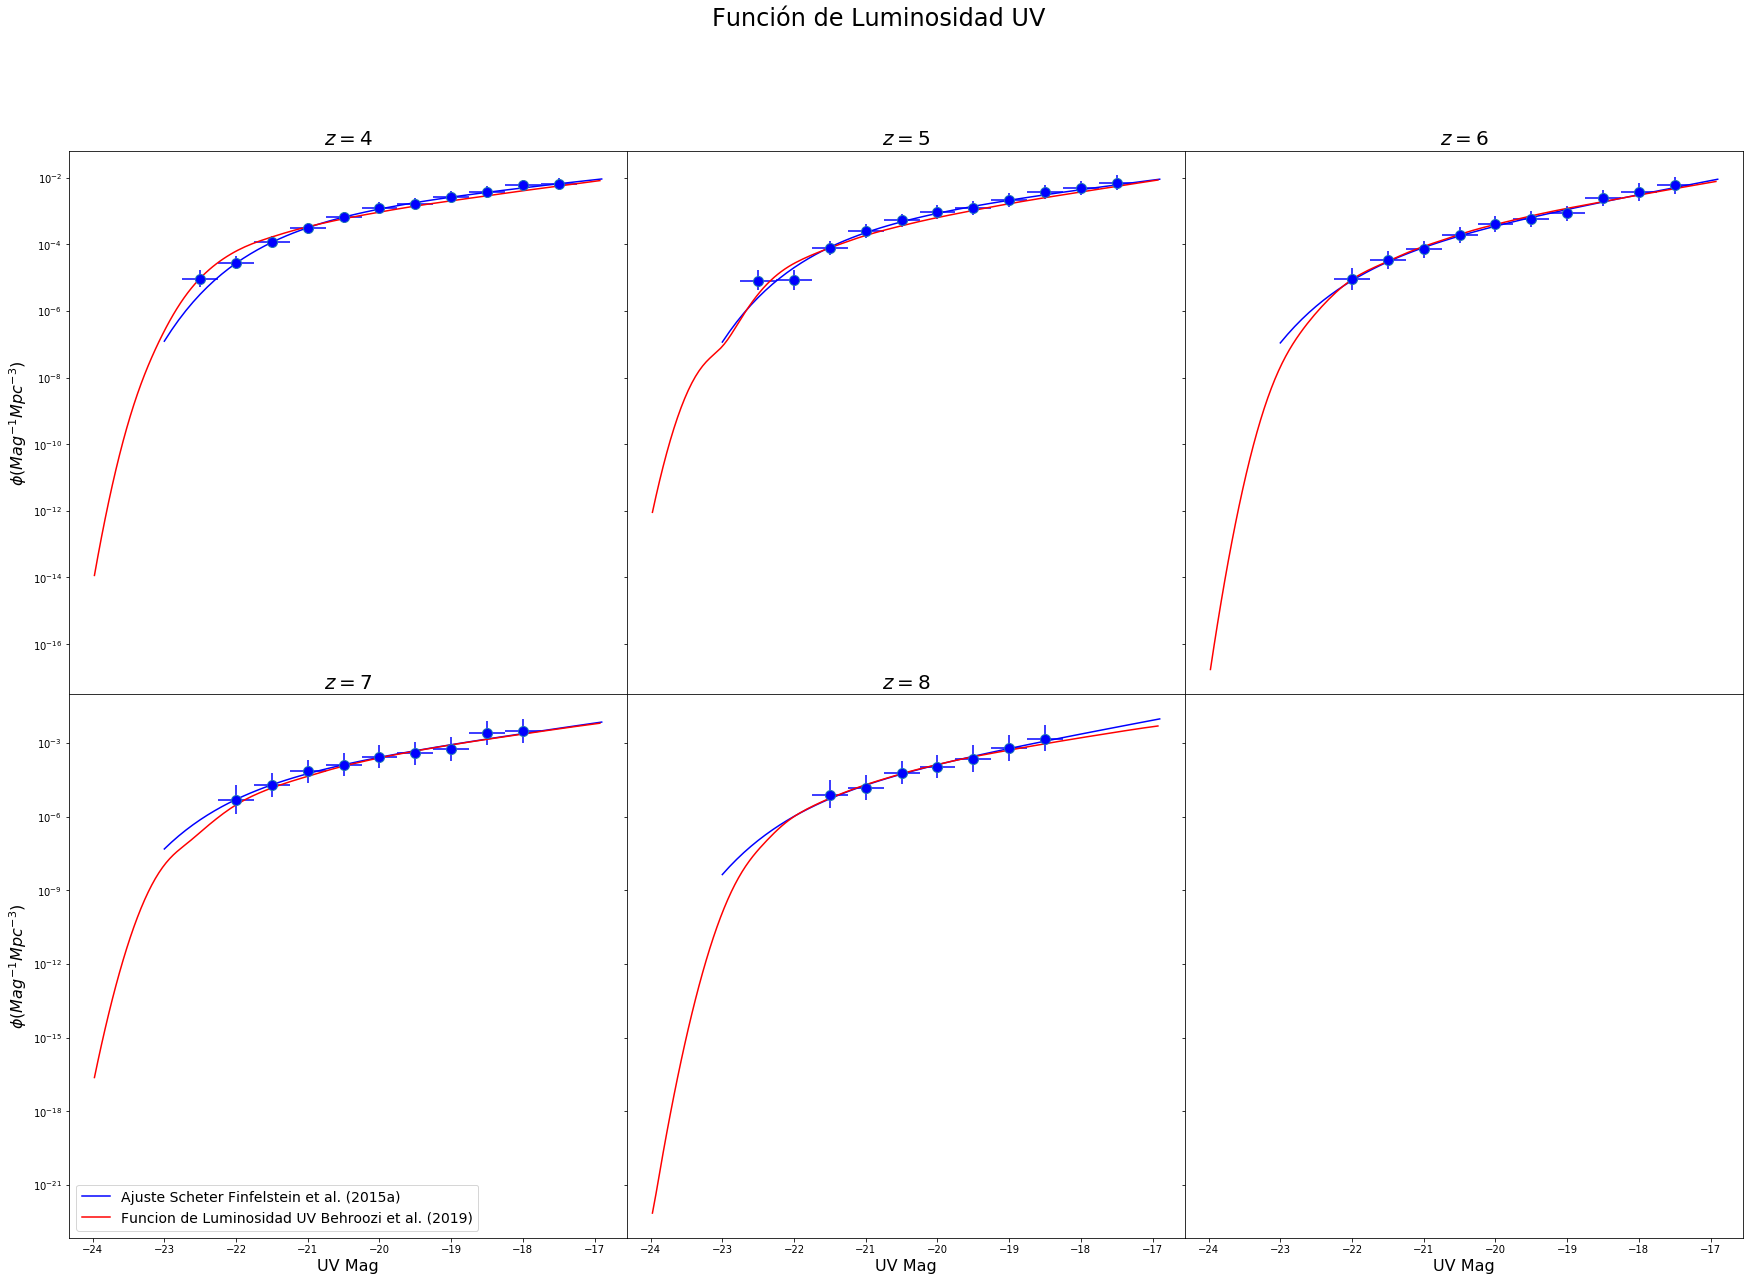

In [28]:
fig, axs = plt.subplots(2, 3,sharex='col',sharey='row',gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(30,20))

(ax1,ax2,ax3),(ax4,ax5,ax6) = axs

#plt.figure(figsize=(50,10))
fig.suptitle("Función de Luminosidad UV", fontsize=24)

#Chart1
#ax1=plt.subplot(1,5,1)
ax1.plot(M,phi(M,4),"b-", label="Ajuste Scheter Finfelstein et al. (2015a)")
ax1.errorbar(phi_fink_z4.loc[:,["bMag","BMag"]].mean(axis=1).values,np.power(10,phi_fink_z4.phi.values),
             yerr=yerror_z4, xerr=xerror_z4,marker='o',ms=10, mfc='b',ecolor="b",linestyle="")
ax1.plot(uvlf_z4["#UV_Center"],uvlf_z4["Number_Density"], "r-",label="Funcion de Luminosidad UV Behroozi et al. (2019)")

ax1.set_title("$z=4$", fontsize=20)
ax1.set_ylabel("$\phi(Mag^{-1}Mpc^{-3})$", fontsize=16)
ax1.set_yscale("log")

#Chart2
#ax2=plt.subplot(1,5,2)
ax2.plot(M,phi(M,5),"b-", label="Ajuste Scheter Finfelstein et al. (2015a)")
ax2.errorbar(phi_fink_z5.loc[:,["bMag","BMag"]].mean(axis=1).values,np.power(10,phi_fink_z5.phi.values),
             yerr=yerror_z5, xerr=xerror_z5,marker='o',ms=10, mfc='b',ecolor="b",linestyle="")
ax2.plot(uvlf_z5["#UV_Center"],uvlf_z5["Number_Density"], "r-",label="Funcion de Luminosidad UV Behroozi et al. (2019)")

ax2.set_title("$z=5$", fontsize=20)
ax2.set_yscale("log")

#Chart3
#ax3=plt.subplot(1,5,3)
ax3.plot(M,phi(M,6),"b-", label="Ajuste Scheter Finfelstein et al. (2015a)")
ax3.errorbar(phi_fink_z6.loc[:,["bMag","BMag"]].mean(axis=1).values,np.power(10,phi_fink_z6.phi.values),
             yerr=yerror_z6, xerr=xerror_z6,marker='o',ms=10, mfc='b',ecolor="b",linestyle="")
ax3.plot(uvlf_z6["#UV_Center"],uvlf_z6["Number_Density"], "r-",label="Funcion de Luminosidad UV Behroozi et al. (2019)")

ax3.set_title("$z=6$", fontsize=20)
ax3.set_yscale("log")

#Chart4
#ax4=plt.subplot(1,5,4)
ax4.plot(M,phi(M,7),"b-", label="Ajuste Scheter Finfelstein et al. (2015a)")
ax4.errorbar(phi_fink_z7.loc[:,["bMag","BMag"]].mean(axis=1).values,np.power(10,phi_fink_z7.phi.values),
             yerr=yerror_z7, xerr=xerror_z7,marker='o',ms=10, mfc='b',ecolor="b",linestyle="")
ax4.plot(uvlf_z7["#UV_Center"],uvlf_z7["Number_Density"], "r-",label="Funcion de Luminosidad UV Behroozi et al. (2019)")
ax4.legend(fontsize=14)

ax4.set_title("$z=7$", fontsize=20)
ax4.set_xlabel("UV Mag", fontsize=16)
ax4.set_ylabel("$\phi(Mag^{-1}Mpc^{-3})$", fontsize=16)
ax4.set_yscale("log")

#Chart5
#ax5=plt.subplot(1,5,5)
ax5.plot(M,phi(M,8),"b-", label="Ajuste Scheter Finfelstein et al. (2015a)")
ax5.errorbar(phi_fink_z8.loc[:,["bMag","BMag"]].mean(axis=1).values,np.power(10,phi_fink_z8.phi.values),
             yerr=yerror_z8, xerr=xerror_z8,marker='o',ms=10, mfc='b',ecolor="b",linestyle="")
ax5.plot(uvlf_z8["#UV_Center"],uvlf_z8["Number_Density"], "r-",label="Funcion de Luminosidad UV Behroozi et al. (2019)")

ax5.set_title("$z=8$", fontsize=20)
ax5.set_xlabel("UV Mag", fontsize=16)
ax5.set_yscale("log")

ax6.set_xlabel("UV Mag", fontsize=16)

fig.savefig("charts/Func_UV.jpg")
fig.show()

$$
f(x)=a e^{-\frac{(x-b)^{2}}{2 c^{2}}}
$$

In [29]:
gaus = lambda x,a,b,sigma:np.exp(-(x-b)**2/(2*sigma**2))*a

def gaus_inv(y,a,b,sigma):
    a1=1
    b1=-2*b
    c1= b**2+2*sigma**2*np.log(y/a)
    return eq_2d(a1,b1,c1) 

def ajuste(x,y,mu):
    mean = np.sum(x*y)/np.sum(y)               
    sigma = np.sqrt(np.sum(y*np.power(x-mean,2))/np.sum(y))
    return curve_fit(gaus,x,y,p0=[1,mu,sigma])

def uvlf_hmf(hmf_z,uvlf_z, charts=False, ax=[]):
    df_itp=hmf_z.sort_values(["#Log10(HM)"], ascending=0)
    df_sample=uvlf_z.sort_values(["#UV_Center"], ascending=1)
    df_itp["Number_Density AC"]=df_itp["Number_Density"].cumsum()
    df_sample["Number_Density AC"]=df_sample["Number_Density"].cumsum()
    
    uv=df_sample["#UV_Center"].values
    n_uv=df_sample["Number_Density"].values
    hm=df_itp["#Log10(HM)"].values
    n_hm=df_itp["Number_Density"].values
    
    mask= hm>=10
    hm=hm[mask]
    n_hm=n_hm[mask]
    
    mu_hm=hm[n_hm==n_hm.max()][0]
    p_hm,_=ajuste(hm,n_hm,mu_hm)
    
    mu_uv=uv[n_uv==n_uv.max()][0]
    p_uv,_=ajuste(uv,n_uv,mu_uv)
    
    s_uv=np.arange(uv.min(),uv.max()+1.1*(uv.max() - uv.min())/1000,(uv.max() - uv.min())/1000)
    s_hm=np.arange(hm.max(),hm.min()+1.1*(hm.min() - hm.max())/1000,(hm.min() - hm.max())/1000)

    def f_uv(x, inverse=False): 
        f_z = lambda z:gaus(z,p_uv[0],p_uv[1],p_uv[2])
        # Integramos para obtener la densidad acumulada
        s_y = np.array([integrate.quad(f_z,-np.infty,i)[0] for i in s_uv])
        #s_y = f_z(s_uv)
         # Una vez que tenemos 1000 puntos interpolamos linealmente
        f_y= interp1d(s_y,s_uv)(x) if inverse else interp1d(s_uv,s_y)(x)
        return f_y
        
    
    def f_hm (y,inverse=False):
        f_z = lambda z:gaus(z,p_hm[0],p_hm[1],p_hm[2])
        # Integramos para obtener la densidad acumulada
        s_y = np.array([integrate.quad(f_z,i,np.infty)[0] for i in s_hm])
        #s_y = f_z(s_hm)
        # Una vez que tenemos 1000 puntos interpolamos linealmente
        f_y= interp1d(s_y,s_hm)(y) if inverse else interp1d(s_hm,s_y)(y)
        return f_y
    
    f = lambda x: f_hm(f_uv(x), True)
    f_z_uv = lambda z:gaus(z,p_uv[0],p_uv[1],p_uv[2])
    f_z_hm = lambda z:gaus(z,p_hm[0],p_hm[1],p_hm[2])
    
    if charts:
        ax1,ax2,ax3,l = ax
        ax1.plot(uv,f_uv(uv), label=l)
        ax2.plot(hm,f_hm(hm),label=l)
        ax3.plot(s_uv,f(s_uv), label=l)
        return f,f_hm,f_uv,f_z_uv,f_z_hm
    else:    
        return f,f_hm,f_uv,f_z_uv,f_z_hm

------------------------------------------------------------
Comienzo del Bucle.
------------------------------------------------------------
------------------------------------------------------------
z=4
------------------------------------------------------------


/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

------------------------------------------------------------
z=5
------------------------------------------------------------


/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

------------------------------------------------------------
z=6
------------------------------------------------------------


/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

------------------------------------------------------------
z=7
------------------------------------------------------------


/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

------------------------------------------------------------
z=8
------------------------------------------------------------


/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/santi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

------------------------------------------------------------
Fin del Bucle
------------------------------------------------------------
------------------------------------------------------------
Parametros de la Gráfica 1
------------------------------------------------------------
------------------------------------------------------------
Parametros de la Gráfica 2
------------------------------------------------------------
------------------------------------------------------------
Parametros de la Gráfica 3
------------------------------------------------------------
------------------------------------------------------------
Gráfica Guardada.
------------------------------------------------------------


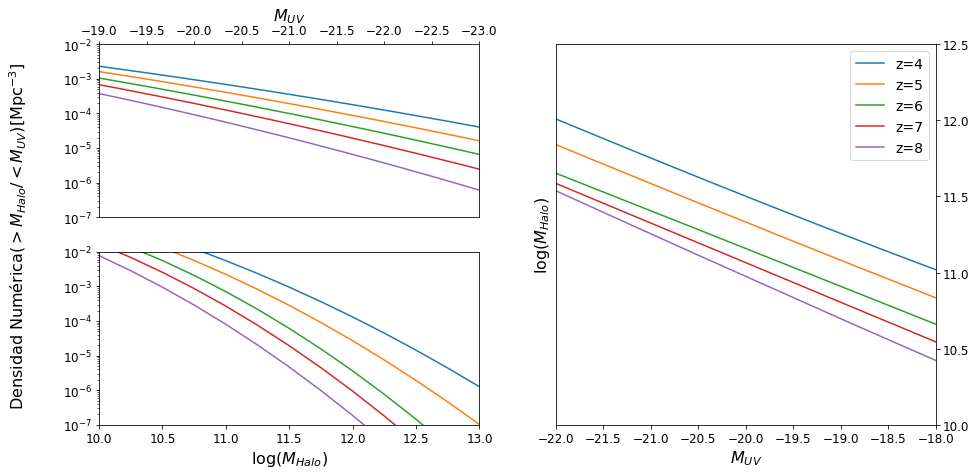

In [30]:
fig = plt.figure(figsize=(15,7))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(122)
fig.text(0.04, 0.5, 'Densidad Numérica($>M_{Halo}/<M_{UV}$)[Mpc$^{-3}$]', va='center', rotation='vertical', fontsize=16)
m_z=[m_z4,m_z5,m_z6,m_z7,m_z8]

print("------------------------------------------------------------")
print("Comienzo del Bucle.")
print("------------------------------------------------------------")

for i in range(5):
    l = "z=%i"%(i+4)
    print("------------------------------------------------------------")
    print(l)
    print("------------------------------------------------------------")
    
    f,f_hm,f_uv,f_z_uv,f_z_hm = uvlf_hmf(hmfs_list[i],uvlfs_list[i],True,[ax1,ax2,ax3,l])
    uv_lim = uvlfs_list[i]["#UV_Center"].max(),uvlfs_list[i]["#UV_Center"].min()
    m_halo = np.zeros(m_z[i].shape[0])
    mask = (m_z[i]["1500Mag"].values<=uv_lim[0]) & (m_z[i]["1500Mag"].values>=uv_lim[1])
    mag_uv = m_z[i]["1500Mag"].values[mask]
    m_halo[mask] = f(mag_uv)
    m_halo[~mask] = np.nan
    m_z[i]["Mh"] = m_halo
    m_z[i]["N"] = f_hm(m_halo)
    m_z[i]["n_hm"] = f_z_hm(m_halo)
    m_z[i]["n_uv"] = f_z_uv(m_z[i]["1500Mag"].values)
    
print("------------------------------------------------------------")
print("Fin del Bucle")
print("------------------------------------------------------------")
print("------------------------------------------------------------")
print("Parametros de la Gráfica 1")
print("------------------------------------------------------------")

ax1.set_xlim(-19,-23)
ax1.set_ylim(10**(-7),10**(-2))
ax1.set_yscale("log")
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position("top")
ax1.set_xlabel("$M_{UV}$", fontsize=16)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)

print("------------------------------------------------------------")
print("Parametros de la Gráfica 2")
print("------------------------------------------------------------")
ax2.set_xlim(10,13)
ax2.set_ylim(10**(-7),10**(-2))
ax2.set_yscale("log")
ax2.set_xlabel("$\log(M_{Halo})$", fontsize=16)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)

print("------------------------------------------------------------")
print("Parametros de la Gráfica 3")
print("------------------------------------------------------------")
ax3.set_xlim(-22,-18)
ax3.set_ylim(10,12.5)
ax3.set_xlabel("$M_{UV}$", fontsize=16)
ax3.set_ylabel("$\log(M_{Halo})$", fontsize=16)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)
#ax3.yaxis.set_label_position('right') 
ax3.yaxis.set_ticks_position("right")
ax3.legend(fontsize=14)

plt.savefig("charts/Fink_halo_uv.jpg")
print("------------------------------------------------------------")
print("Gráfica Guardada.")
print("------------------------------------------------------------")

In [31]:
# Z=7
f= uvlf_hmf(hmfs_list[3],uvlfs_list[3])[0]
f(-21)

array(11.32584211)

**Comparar con el HMF**

In [32]:
!head -n 12 HMFCalc/Seth_WMAP7/mVector_z\=4\ .txt


# [1] m:            [M_sun/h] 
# [2] sigma 
# [3] ln(1/sigma) 
# [4] n_eff 
# [5] f(sigma) 
# [6] dn/dm:        [h^4/(Mpc^3*M_sun)] 
# [7] dn/dlnm:      [h^3/Mpc^3] 
# [8] dn/dlog10m:   [h^3/Mpc^3] 
# [9] n(>m):        [h^3/Mpc^3] 
# [11] rho(>m):     [M_sun*h^2/Mpc^3] 
# [11] rho(<m):     [M_sun*h^2/Mpc^3] 
# [12] Lbox(N=1):   [Mpc/h]


In [33]:
#Parametros WMAP7
h = 0.704

In [34]:
archivos = ["HMFCalc/Seth_WMAP7/mVector_z=4 .txt","HMFCalc/Seth_WMAP7/mVector_z=5 .txt",
           "HMFCalc/Seth_WMAP7/mVector_z=6 .txt","HMFCalc/Seth_WMAP7/mVector_z=7 .txt",
           "HMFCalc/Seth_WMAP7/mVector_z=8 .txt"]
hmfcalc_list=[]

for a in archivos:
    hmfcalc_z=pd.read_csv(a,sep="\s",header=None, skiprows=12)
    hmfcalc_z = hmfcalc_z.iloc[:,[0,7,11]]
    hmfcalc_z=hmfcalc_z.rename(columns={0:"M_h",7:"dn/dlnm",11:"Lbox"})
    hmfcalc_z["M_h"]=np.log10(hmfcalc_z["M_h"].values*h)
    hmfcalc_list.append(hmfcalc_z)

/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


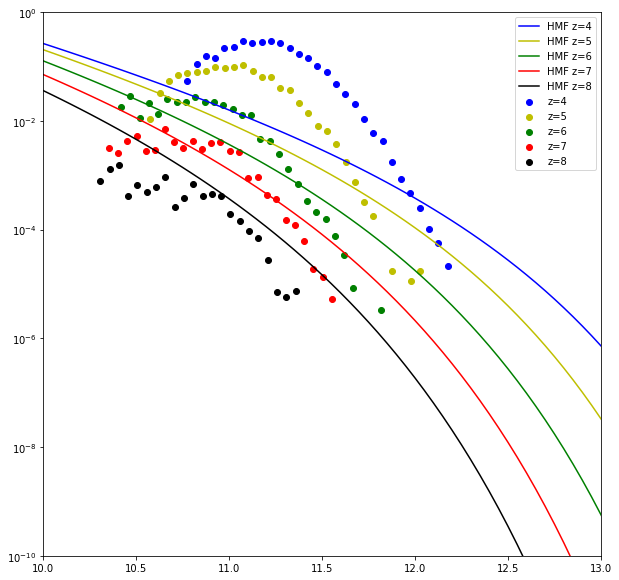

In [35]:
plt.figure(figsize=(10,10))
z=4
dic={}
col_dic=[]
colors=["b","y","g","r","k"]
for m in m_z:
    hmfcalc_z=hmfcalc_list[z-4]
    m_array=m["Mh"].values
    n_array=m["N"].values
    n_array = n_array[~np.isnan(m_array)]
    m_array = m_array[~np.isnan(m_array)]
    l="z=%i"%(z)
    m_sample = np.arange(m_array.min(),m_array.max()+0.05,0.05)
    cuentas = np.array([ np.sum(n_array[(m_array >= m_i-0.025) & (m_array<m_i+0.025)])*h**3 for m_i in m_sample])
    n_array=cuentas/np.sum(cuentas)
    plt.plot(hmfcalc_z.M_h,hmfcalc_z["dn/dlnm"], label="HMF z=%i"%(z), color=colors[z-4])
    plt.scatter(m_sample,cuentas,c=colors[z-4],label=l)
    z+=1

plt.yscale("log")
plt.xlim(10,13)
plt.ylim(10**(-10),10**(-0))
plt.legend()

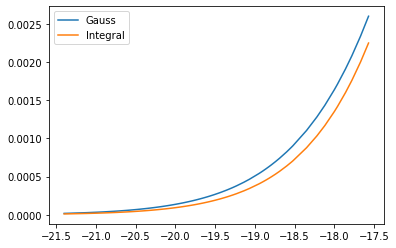

In [22]:
f,f_hm,f_uv,f_z_uv,f_z_hm= uvlf_hmf(hmfs_list[i],uvlfs_list[i])
uv_lim = uvlfs_list[i]["#UV_Center"].max(),uvlfs_list[i]["#UV_Center"].min()
mask = (m_z[i]["1500Mag"].values<=uv_lim[0]) & (m_z[i]["1500Mag"].values>=uv_lim[1])
mag_uv = m_z[i]["1500Mag"].values[mask]
mag_uv.sort()
plt.plot(mag_uv,f_z_uv(mag_uv),label="Gauss")
plt.plot(mag_uv,f_uv(mag_uv),label="Integral")
plt.legend()

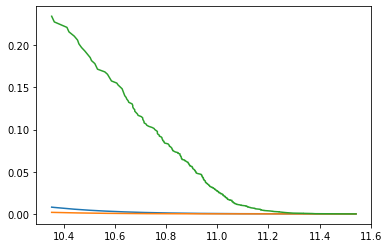

In [127]:
f,f_hm,f_uv,f_z_uv,f_z_hm= uvlf_hmf(hmfs_list[i],uvlfs_list[i])
m_halo = m_z7['Mh'].values
m_halo = m_halo[~np.isnan(m_halo)]
m_halo.sort()
plt.plot(m_halo,f_z_hm(m_halo))
plt.plot(m_halo,f_hm(m_halo))
plt.plot(m_halo,f_z_hm(m_halo)[-1::-1].cumsum()[-1::-1]/(m_halo[-1]-m_halo[0]))

In [38]:

cuentas/cuentas.sum()

array([0.07914573, 0.69472362, 0.22361809, 0.00251256])

## Distribución de los datos de [Behroozi et al. (2019)](#Referencias)

In [185]:
!head -n 29 "Behroozi/sfr_catalog_0.073623.txt"

#ID DescID UPID Flags Uparent_Dist X Y Z VX VY VZ M V MP VMP R Rank1 Rank2 RA RARank SM ICL SFR obs_SM obs_SFR SSFR SM/HM obs_UV
#Columns:
#ID: Unique halo ID
#DescID: ID of descendant halo (or -1 at z=0).
#UPID: -1 for central halos, otherwise, ID of largest parent halo
#Flags: Ignore
#Uparent_Dist: Ignore
#X Y Z: halo position (comoving Mpc/h)
#VX VY VZ: halo velocity (physical peculiar km/s)
#M: Halo mass (Bryan & Norman 1998 virial mass, Msun)
#V: Halo vmax (physical km/s)
#MP: Halo peak historical mass (BN98 vir, Msun)
#VMP: Halo vmax at the time when peak mass was reached.
#R: Halo radius (BN98 vir, comoving kpc/h)
#Rank1: halo rank in Delta_vmax (see UniverseMachine paper)
#Rank2, RA, RARank: Ignore
#SM: True stellar mass (Msun)
#ICL: True intracluster stellar mass (Msun)
#SFR: True star formation rate (Msun/yr)
#Obs_SM: observed stellar mass, including random & systematic errors (Msun)
#Obs_SFR: observed SFR, including random & systematic errors (Msun/yr)
#SSFR: observed SSFR
#

In [184]:
bolshoi = pd.read_csv("Behroozi/sfr_catalog_0.073623.txt", sep="\s", skiprows=29)
bolshoi

/Users/santi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,#ID,DescID,UPID,Flags,Uparent_Dist,X,Y,Z,VX,VY,...,RA,RARank,SM,ICL,SFR,obs_SM,obs_SFR,SSFR,SM/HM,obs_UV
0,405434,627025,-1,2,2.0,10.700050,24.257339,29.222601,-8.670000,45.330002,...,1.213039,1.541433,10190000.0,0.0,0.678400,11370000.0,0.645200,5.676000e-08,0.002982,-17.749
1,405437,627028,-1,2,2.0,9.471750,24.515860,28.488449,63.500000,15.510000,...,-0.873632,0.101669,4483000.0,0.0,0.347000,461600.0,0.330000,7.149000e-07,0.000678,-17.026
2,405439,627033,-1,2,2.0,9.332960,24.412491,26.648420,41.970001,-21.020000,...,-0.649631,0.570677,17150000.0,0.0,0.187600,16360000.0,0.178400,1.091000e-08,0.002688,-17.188
3,405629,627319,-1,3,2.0,18.271070,18.654341,46.963711,-120.660004,161.929993,...,-1.444936,-1.444936,855400.0,0.0,0.115200,1105000.0,0.109500,9.916000e-08,0.000289,-15.700
4,405630,627320,-1,3,2.0,18.023230,19.298660,47.493092,-109.010002,73.639999,...,-0.447806,-0.447806,52220.0,0.0,0.007031,50920.0,0.006687,1.313000e-07,0.000046,-12.717
5,405631,627323,-1,3,2.0,17.358450,18.844521,46.709560,-15.330000,159.169998,...,1.906949,1.906949,58700.0,0.0,0.007904,50370.0,0.007517,1.492000e-07,0.000129,-12.843
6,405634,627326,-1,2,2.0,17.496620,19.623699,47.060810,-47.169998,63.680000,...,-0.939994,-1.048224,241900.0,0.0,0.001367,345600.0,0.001300,3.763000e-09,0.000265,-13.109
7,405637,627329,-1,2,2.0,17.569040,19.675470,49.013000,-46.430000,67.080002,...,-1.260807,-0.919974,2711000.0,0.0,0.097960,1496000.0,0.093170,6.226000e-08,0.000661,-16.122
8,405639,627332,-1,3,2.0,19.749479,17.685520,46.604599,-138.339996,160.080002,...,1.026307,1.026307,99420.0,0.0,0.013390,191900.0,0.012730,6.633000e-08,0.000145,-13.410
9,405640,627333,-1,2,2.0,16.221670,19.606350,48.948502,47.189999,70.290001,...,0.957268,1.164022,108300000.0,0.0,2.200000,117300000.0,2.092000,1.783000e-08,0.011320,-19.129


## Función de Masa de Halo Teórica

Las predicciones teóricas de la función de masa de halo presentadas en [Steinhardt et al. (2016)](#Referencias) fueron calculadas a través de HMFCalc ([Murray et al. (2013)](#Referencias)) usando las estimaciones de [Sheth et al. (2001)](#Referencias).

Para comenzar, ([Murray et al. (2013)](#Referencias).) he instalado tanto la libreria [hmf](https://github.com/steven-murray/hmf) como la app-web diseñada con el framework Django [HMFcalc](http://hmf.icrar.org/) <a id="sfn1" href="#fn1">$^{(1)}$</a>. Ésta última me ha parecido una muy buena opción debido a que su uso es bastante sencilla y que la integración de los datos de [Behroozi et al. (2019)](#Referencias) creo que se podría realizar con mayor facilidad, sin embargo presenta una versión mucho menos actualizada de *hmf* el cual es el código base de la parte de cálculos de la app-web. De todas formas, se estudiarán la integración de los nuevos datos en ambas opciones con la intención de poder compartir las versiones en sus respectivos repositorios de GitHub, aunque los cálculos finales se realizarán con la última versión de *hmf*.<a id="sfn2" href="#fn2">$^{(2)}$</a>





***
<a id="fn1" href="#sfn1">$(1)$</a> La versión de Django usada en esta aplicación es la 1.4, donde el código de la app web es solo compatible para las versiones de Python 2.x.

<a id="fn2" href="#sfn2">$(2)$</a> Otra de las opciones para el cálculo de la función de masa de halo ([Murray et al. (2013)](#Referencias)) la presenta la librería de python [yt](https://yt-project.org/) utilizada en la explotación de los datos de RAMSES.

# Notas

Parece que los datos de Behroozi no aportan nuevas parámetros de entrada para el HMF de Murray. Esto tirá un poco al traste lo pensado hasta ahora. Sin embargo, el HMF de Steindarht usa la función de ajuste de Seth, la cual parece estar basada en un universo Eisntein-deSitter y eso me ha llevado a pensar si se están usando las suposiciones de los parámetros correctas. Podemos intentar usar Reed2003 u otras funciones añadidas a posteriori que puedan encajar mejor ¿Cómo cambiaría los datos.?

Por otro lado me he descargado los datos de [Behroozi](https://www.peterbehroozi.com/data.html) y [CANDELS](http://behroozi.users.hpc.arizona.edu/UniverseMachine/DR1/Lightcones/)

In [10]:
!head ../../CANDELS/test.dat

#RA Dec Z(los) Z(cosmo) Scale ID DescID UPID Flags Uparent_Dist X Y Z VX VY VZ M V MP VMP R Rank1 Rank2 RA RARank SM ICL SFR obs_SM obs_SFR SSFR SM/HM obs_UV A_UV
150.175095 2.018628 9.880285 9.877687 0.092748 6851068 9152134 -1 3 2.000000 6534.355469 -5.020020 -34.424805 71.617088 17.460934 121.908783 4.557e+08 29.410000 4.557e+08 29.410000 16.964001 -1.615942 -0.487957 0.611189 0.611189 7.239e+03 0.000e+00 5.918e-04 1.692e+03 5.636e-04 3.331e-07 1.588e-05 -10.292 0.003
150.172134 2.022606 9.878959 9.878014 0.092748 6851070 9152137 -1 3 2.000000 6534.407715 -4.683105 -33.970947 26.046215 10.250401 35.217655 9.116e+08 40.009998 9.116e+08 40.009998 21.372999 0.144509 -0.626174 -0.236655 -0.236655 3.652e+04 0.000e+00 2.986e-03 6.193e+04 2.843e-03 4.591e-08 4.006e-05 -12.044 0.008
150.207108 2.023004 9.863716 9.860533 0.092748 6851107 9152181 -1 2 2.000000 6531.767090 -8.666504 -33.916748 87.882950 124.358871 86.346741 5.013e+09 92.360001 5.013e+09 92.360001 37.728001 0.465176 -0.293483 0

## Referencias

- Steinhardt, C. L., Capak, P., Masters, D., & Speagle, J. S. (2016). The impossibly early galaxy problem. *The Astrophysical Journal, 824(1)*, 21.

- Steinhardt, C. L., & Speagle, J. S. (2014). A uniform history for galaxy evolution. *The Astrophysical Journal, 796(1)*, 25.

- Behroozi, P., Wechsler, R. H., Hearin, A. P., & Conroy, C. (2019). UniverseMachine: The correlation between galaxy growth and dark matter halo assembly from z= 0− 10. *Monthly Notices of the Royal Astronomical Society, 488(3)*, 3143-3194.

- Murray, S. G., Power, C., & Robotham, A. S. G. (2013). HMFcalc: An online tool for calculating dark matter halo mass functions. *Astronomy and Computing, 3*, 23-34.

- Sheth, R. K., Mo, H. J., & Tormen, G. (2001). Ellipsoidal collapse and an improved model for the number and spatial distribution of dark matter haloes. *Monthly Notices of the Royal Astronomical Society, 323(1)*, 1-12.

- Hildebrandt, H., Pielorz, J., Erben, T., van Waerbeke, L., Simon, P., & Capak, P. (2009). CARS: the CFHTLS-Archive-Research Survey-II. Weighing dark matter halos of Lyman-break galaxies at z= 3–5. *Astronomy & Astrophysics, 498(3)*, 725-736.

- a) Bouwens, R. J., Illingworth, G. D., Oesch, P. A., Caruana, J., Holwerda, B., Smit, R., & Wilkins, S. (2015). Reionization after Planck: the derived growth of the cosmic ionizing emissivity now matches the growth of the galaxy UV luminosity density. *The Astrophysical Journal, 811(2)*, 140.

- b) Bouwens, R. J., Illingworth, G. D., Oesch, P. A., Trenti, M., Labbé, I., Bradley, L., ... & Franx, M. (2015). UV luminosity functions at redshifts z∼ 4 to z∼ 10: 10,000 galaxies from HST legacy fields. *The Astrophysical Journal, 803(1)*, 34.

- a) Finkelstein, S. L., Ryan Jr, R. E., Papovich, C., Dickinson, M., Song, M., Somerville, R. S., ... & Ashby, M. L. (2015). The evolution of the galaxy rest-frame ultraviolet luminosity function over the first two billion years. The Astrophysical Journal, 810(1), 71.

- b) Finkelstein, S. L., Song, M., Behroozi, P., Somerville, R. S., Papovich, C., Milosavljević, M., ... & Fazio, G. G. (2015). An increasing stellar baryon fraction in bright galaxies at high redshift. The Astrophysical Journal, 814(2), 95.

- Wang, T., Schreiber, C., Elbaz, D., Yoshimura, Y., Kohno, K., Shu, X., ... & Lim, C. F. (2019). A dominant population of optically invisible massive galaxies in the early Universe. Nature, 572(7768), 211-214.